In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import folium
from folium.plugins import FloatImage
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

In [3]:
listings =pd.read_csv('data/listings.csv.gz', compression='gzip')
calendar = pd.read_csv('data/calendar.csv.gz', compression='gzip')
reviews = pd.read_csv('data/reviews.csv.gz', compression='gzip')

In [4]:
calendar.head(5)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,23742,2020-03-16,f,$120.00,$120.00,5,45
1,22979,2020-03-16,f,$70.00,$70.00,3,15
2,22979,2020-03-17,f,$70.00,$70.00,3,15
3,22979,2020-03-18,f,$70.00,$70.00,3,15
4,22979,2020-03-19,f,$70.00,$70.00,3,15


In [5]:
listings.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3109,https://www.airbnb.com/rooms/3109,20200315231126,2020-03-16,zen and calm,Appartement très calme de 50M2 Utilisation de ...,I bedroom appartment in Paris 14,I bedroom appartment in Paris 14 Good restaura...,none,Good restaurants very close the Montparnasse S...,NaN,RER B Metro Ligne 13 Pernety Metro Ligne 13 Pl...,"A la demande, vous pouvez avoir accès à la cha...",yes I can help you out,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/baeae9e2-c...,NaN,3631,https://www.airbnb.com/users/show/3631,Anne,2008-10-14,"Paris, Île-de-France, France",NaN,within a few hours,100%,40%,f,https://a0.muscache.com/im/users/3631/profile_...,https://a0.muscache.com/im/users/3631/profile_...,Alésia,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Paris, Île-de-France, France",XIV Arrondissement,Observatoire,NaN,Paris,Île-de-France,75014,Paris,"Paris, France",FR,France,48.83349,2.31852,...,1.0,Real Bed,"{Internet,Wifi,Kitchen,""Paid parking off premi...",NaN,$60.00,$490.00,NaN,$150.00,$60.00,1,$0.00,2,30,2,2,30,30,2.0,30.0,3 weeks ago,t,16,46,76,351,2020-03-16,9,1,2016-12-27,2019-10-24,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,NaN,"{""translation missing: en.occupancy.taxes.juri...",f,f,flexible,f,f,1,1,0,0,0.23
1,5396,https://www.airbnb.com/rooms/5396,20200315231126,2020-03-16,Explore the heart of old Paris,"Cozy, well-appointed and graciously designed s...","Small, well appointed studio apartment at the ...","Cozy, well-appointed and graciously designed s...",none,"You are within walking distance to the Louvre,...",The staircase leading up to the apartment is n...,The flat is close to two or three major metro ...,"The flat includes its own modern bathroom, a w...",We expect guests to operate rather independent...,This is a small flat in a very old building th...,NaN,NaN,https://a0.muscache.com/im/pictures/52413/f9bf...,NaN,7903,https://www.airbnb.com/users/show/7903,Borzou,2009-02-14,"Istanbul, İstanbul, Turkey",We are both journalists based in the Middle Ea...,within an hour,100%,100%,f,https://a0.muscache.com/im/users/7903/profile_...,https://a0.muscache.com/im/users/7903/profile_...,Saint-Paul - Ile Saint-Louis,1.0,1.0,"['email', 'phone', 'facebook', 'google', 'revi...",t,t,"Paris, Ile-de-France, France",IV Arrondissement,Hôtel-de-Ville,NaN,Paris,Ile-de-France,75004,Paris,"Paris, France",FR,France

### Reviews

In [6]:

reviews.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3109,123127969,2016-12-27,12389804,Sophie,The host canceled this reservation the day bef...
1,3109,123274144,2016-12-28,67553494,Tom'S,The host canceled this reservation 2 days befo...
2,3109,207127433,2017-10-28,51636494,Patricia,Tout s'est bien déroulé. Merci bien. PG
3,3109,208779822,2017-11-03,4142888,Patricia,Un petit nid fouiller douillet situé dans app...
4,3109,234257457,2018-02-12,3539452,Dominique,The host canceled this reservation 8 days befo...


In [7]:
calendar['available'] = calendar.available.map(lambda x: 1 if x == 't' else 0)

In [8]:
calendar.date = pd.to_datetime(calendar.date)

In [9]:
calendar['price'] = calendar['price'].str.replace('$', '').str.replace(',', '')
calendar['price'] = calendar['price'].astype(float)

In [10]:
calendar_365 = calendar.groupby(
    'date')['available', 'price'].mean().reset_index()
calendar_365.rename(
    columns={'price': 'average_price', 'available': 'vacancy'}, inplace=True)
calendar_365['occupancy'] = (1 - calendar_365['vacancy']) * 100
calendar_365['dayofweek'] = calendar_365.date.dt.weekday_name.str[:3]
calendar_365['month'] = calendar_365.date.dt.month_name().str[:3]

In [11]:
def plot_calendar(groupby_col, agg_col):
    df_index = list(calendar_365[groupby_col].unique())
    grouped_df = calendar_365.groupby(
        groupby_col)[agg_col].mean().reindex(df_index)

    plt.plot(grouped_df)
    plt.ylabel(agg_col.replace('_', ' ').title())
    plt.title(" {} by {}".format(agg_col.replace('_', ' ').title(),
                                 groupby_col.title()), fontsize=18, fontweight='bold')
    ticks = list(range(len(df_index)))
    labels = df_index
    plt.xticks(ticks, labels)
    plt.show()

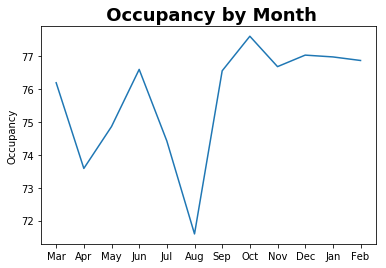

In [12]:
plot_calendar('month', 'occupancy')

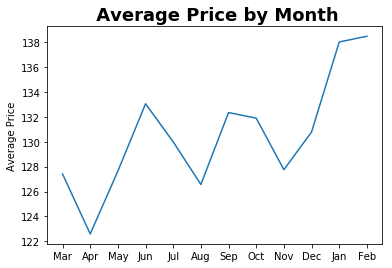

In [13]:
plot_calendar('month', 'average_price')

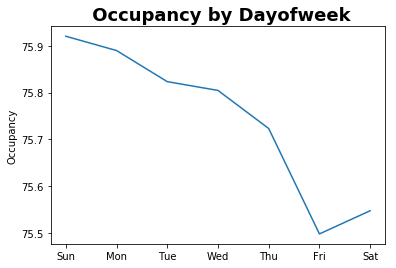

In [14]:
plot_calendar('dayofweek', 'occupancy')

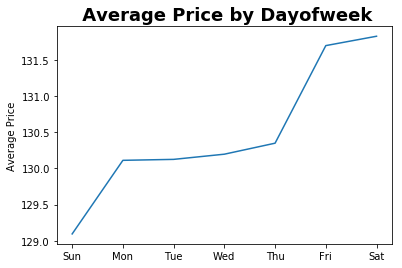

In [15]:
plot_calendar('dayofweek', 'average_price')

In [16]:
listings.price = listings.price.str.replace('$', '').str.replace(',', '')
listings['price'] = listings['price'].astype(float)

Text(0.5,1,'Boxplot for listings.price.')

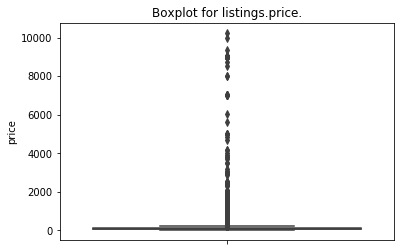

In [17]:
sns.boxplot(listings.price, orient='v').set_title(
    'Boxplot for listings.price.')

In [18]:
listings['price'].describe()

count    67323.000000
mean       129.002837
std        266.863166
min          0.000000
25%         60.000000
50%         85.000000
75%        125.000000
max      10250.000000
Name: price, dtype: float64

In [19]:
def group_plot(df, groupby_col, agg_col, plot_type, top_k=10):
    if plot_type == 'count':

        if agg_col == 'id':
            grouped_df = df.groupby(groupby_col)[agg_col].count()
            order_index = grouped_df.sort_values(ascending=False).index[:top_k]
            splot = sns.countplot(x=groupby_col, data=df,
                                  palette="Set1", order=order_index)

            for p in splot.patches:
                splot.annotate(format(p.get_height(), '.0f'), (p.get_x()+p.get_width()/2., p.get_height()),
                               rotation=90, ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')

            plt.xlabel('Neighborhood')
            plt.ylabel('Listings count')
            plt.title('Top neighborhoods based on listing counts',
                      fontsize=18, fontweight='bold')

        elif agg_col == 'price_bins':
            bins = [0, 101, 201, 301, 401, 501, 1000]
            group = ['1-100', '101-200', '201-300',
                     '301-400', '400-500', '500+']

            df['price_bins'] = pd.cut(df['price'], bins, labels=group)

            grouped_df = df.groupby(groupby_col)['price'].median()
            order_index = grouped_df.sort_values(ascending=False).index[:top_k]
            splot = sns.countplot(x=groupby_col, data=df, hue='price_bins',
                                  orient='h', palette="Set1", order=order_index)
            for p in splot.patches:
                splot.annotate(format(p.get_height(), '.0f'), (p.get_x()+p.get_width()/2., p.get_height()),
                               rotation=90, ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')

            plt.xlabel('Neighborhood')
            plt.ylabel('Price bins count')
            plt.title('Top neighborhoods price distribution',
                      fontsize=18, fontweight='bold')
            plt.legend(loc='upper right')

    elif plot_type == 'box':
        grouped_df = df.groupby(groupby_col)[agg_col].median()
        order_index = grouped_df.sort_values(ascending=False).index[:top_k]
        sns.boxplot(x=groupby_col, y=agg_col, data=df,
                    palette="Set1", order=order_index)

        plt.xlabel('Neighborhood')
        plt.ylabel('Price')
        plt.title('Top neighborhoods based on listing prices',
                  fontsize=18, fontweight='bold')

    plt.xticks(
        rotation=45,
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large'
    )

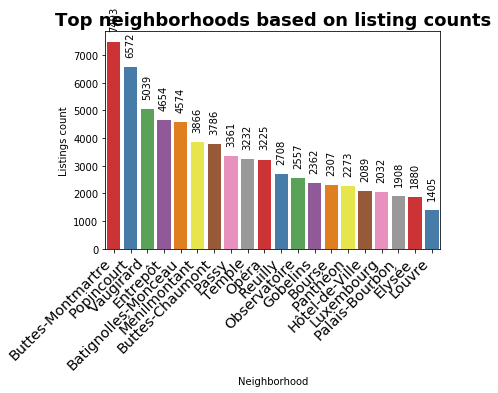

In [20]:
group_plot(listings, 'neighbourhood_cleansed', 'id', 'count', 25)

In [38]:
def plot_top_neighborhood_locations(df, groupby_col):
    latitude = 48.8566
    longitude = 2.3522

    color_list = ['red', 'blue', 'gray', 'darkred', 'lightgreen',
                  'orange', 'black', 'cadetblue', 'darkgreen', 'purple']

    grouped_df = df.groupby(groupby_col)['id'].count()
    top_nbrhd_list = list(grouped_df.sort_values(ascending=False).index[:10])
    top_nbrhd = listings[listings[groupby_col].isin(top_nbrhd_list)]
    colormap = dict(zip(top_nbrhd_list, color_list))
    paris_map = folium.Map(location=[latitude, longitude], zoom_start=12)
    incidents = folium.map.FeatureGroup()

    for lat, lng, nbrhd in zip(top_nbrhd.latitude, top_nbrhd.longitude, top_nbrhd[groupby_col]):
        if nbrhd in colormap:
            nbrhd_color = colormap[nbrhd]
            incidents.add_child(
                folium.vector_layers.CircleMarker(
                    [lat, lng],
                    radius=1.0, 
                    color=nbrhd_color,
                    fill=False,
                    popup=nbrhd,
                    fill_color='blue',
                    fill_opacity=0.05
                )
            )
    paris_map.add_child(incidents)


    return paris_map

In [28]:
plot_top_neighborhood_locations(listings, 'neighbourhood_group_cleansed')

In [39]:
group_plot(top_nbrhd, 'neighbourhood_cleansed', 'price_bins', 'count', 25)

NameError: name 'top_nbrhd' is not defined

Text(0.5,1,'Price vs Number of Reviews')

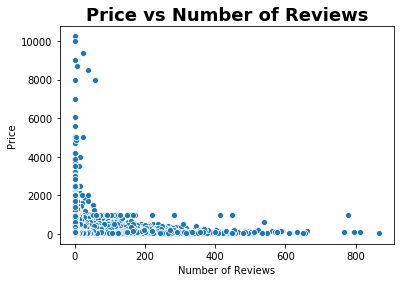

In [30]:
sns.scatterplot(x=listings['number_of_reviews'], y=listings['price'])
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.title('Price vs Number of Reviews', fontsize=18, fontweight='bold')